In [77]:
# Import libraries
import math
import pandas as pd
import numpy as np
import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context = 'talk', font_scale = 1.05)

In [78]:
# Load Data
data = pd.read_csv('processed_data_I.csv')
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data = data.loc[data['iso_a3'] != 'USA']

# Update columns & country names to have no spaces
data.rename(columns = {'GDP per capita': 'GDP',
                       'Curr Acc Balance': 'CA',
                       'labor comp per capita': 'labsh'}, inplace = True)
data['country_name'] = data['country_name'].str.replace(' ', '_')

### 1. Pooled OLS Regression Model - Base Model

In [79]:
# Set endogenous & exogenous variables
y_var_name = 'big_mac_index'

X_var_names = ['GDP', 
               'CA', 
               'GGB', 
               'labsh']

# Create y vector & X matrix
pooled_y = data[y_var_name]
pooled_X = data[X_var_names]

# Set interncept
pooled_X = sm.add_constant(pooled_X)

# Build Pooled OLS Regression Model
pooled_ols_model = sm.OLS(endog = pooled_y, exog = pooled_X).fit()

# Print results
print(pooled_ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:          big_mac_index   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     73.97
Date:                Tue, 31 May 2022   Prob (F-statistic):           2.95e-44
Time:                        00:29:27   Log-Likelihood:                -1474.4
No. Observations:                 323   AIC:                             2959.
Df Residuals:                     318   BIC:                             2978.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -70.7804     10.899     -6.494      0.0

### Analysis of Residual Errors

**Are residuals normally distributed with Mean 0?**

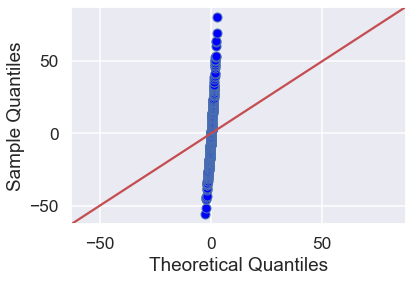

In [80]:
sm.qqplot(data = pooled_ols_model.resid, line = '45')
plt.show()

**Are residuals homoskedastic?**

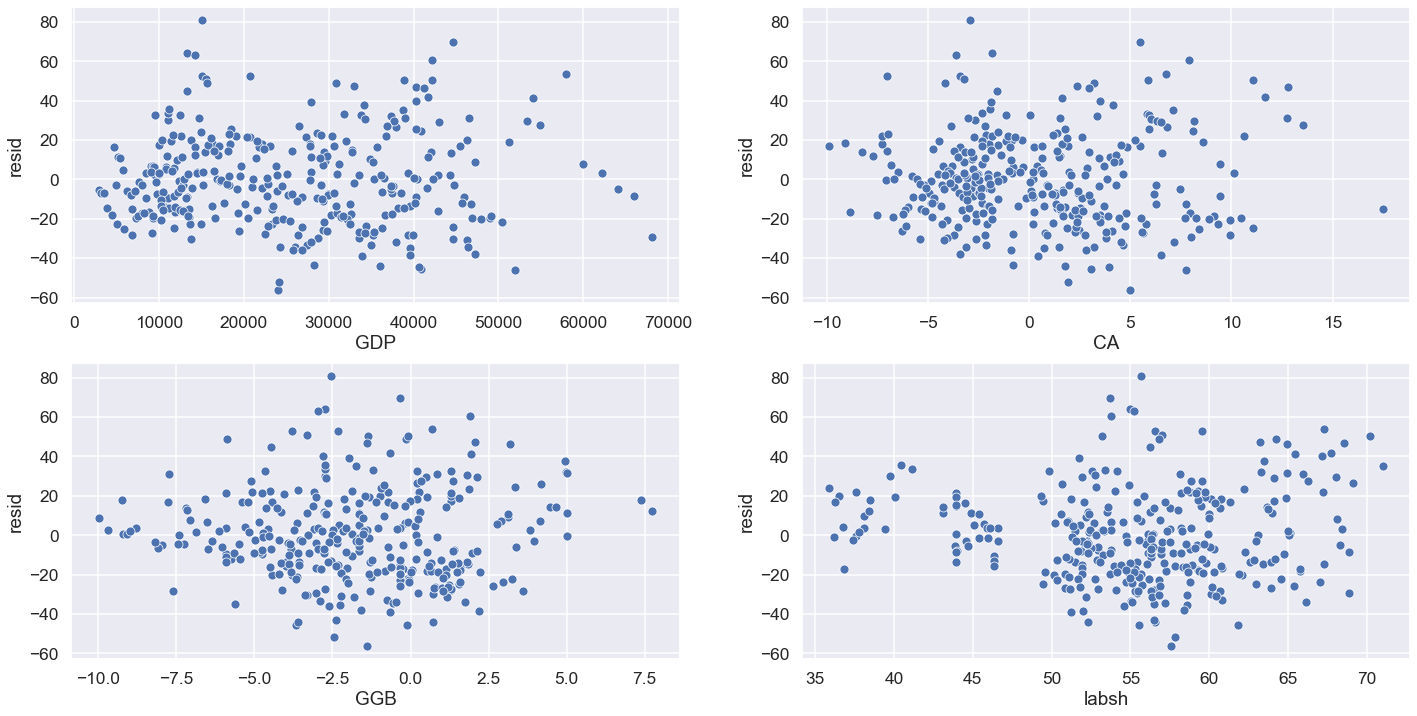

In [81]:
data['resid'] = pooled_ols_model.resid
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 12))

for ix, c in enumerate(X_var_names):
    plt.sca(ax[ix//2, ix%2])
    sns.scatterplot(data = data, x = c, y = 'resid')

Lagrange Multiplier Test for Homoskedasticity

Null Hypothesis of White Test (LM): Residuals are homoskedastic

Alternate Hypothesis: Residuals are not homoskedastic

<br></br>

In [82]:
from statsmodels.stats.diagnostic import het_white

results = het_white(resid = data.resid, exog = pooled_X)
results

(42.722016682309196,
 9.489383574394067e-05,
 3.353400634203427,
 4.8546134140617816e-05)

**Are the errors correlated with response variable y?**

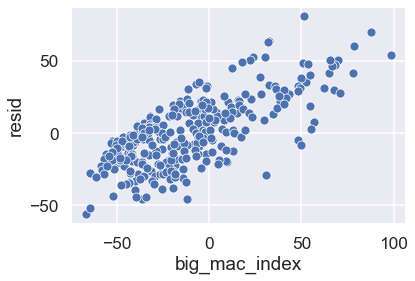

In [83]:
sns.scatterplot(data = data, x = 'big_mac_index', y = 'resid')
plt.show()

In [84]:
# Show pearson correlation:
print(data[['resid','big_mac_index']].corr())

                  resid  big_mac_index
resid          1.000000       0.719733
big_mac_index  0.719733       1.000000


**Are the residuals autocorrelated?**

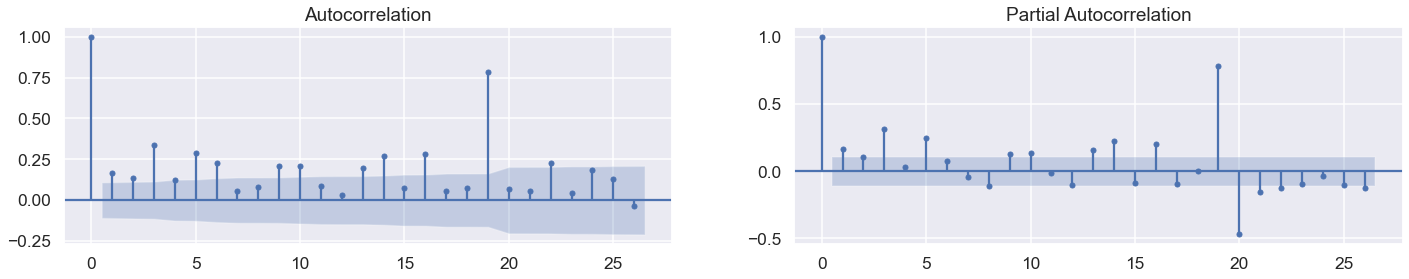

In [85]:
# Plot ACF & PACF:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 4))
tsaplots.plot_acf(data.resid, ax = ax[0])
tsaplots.plot_pacf(data.resid, ax = ax[1])
plt.show()

### 2. Fixed Effects Regression Model - M1

In [86]:
# Select units & times
unit_col_name = 'country_name'
time_period_col_name = 'year'

# Create dummy variable for each country
data
data_dummies = pd.get_dummies(data[unit_col_name])
data_panel_with_dummies = data.join(data_dummies)

# Set endogenous & exogenous variables
y_var_name = 'big_mac_index'
X_var_names = ['GDP', 'CA', 'GGB', 'labsh']

# Set units of interest
unit_names = data['country_name'].drop_duplicates().to_list()
unit_names.sort()

# Build Fixed Effects LSDV Regression Formula 
lsdv_expr = y_var_name + ' ~ '
i = 0
for X_var_name in X_var_names:
    if i > 0:
        lsdv_expr = lsdv_expr + ' + ' + X_var_name
    else:
        lsdv_expr = lsdv_expr + X_var_name
    i = i + 1
for dummy_name in unit_names[:-1]:
    lsdv_expr = lsdv_expr + ' + ' + dummy_name

print('Regression expression for OLS with dummies=' + lsdv_expr)

Regression expression for OLS with dummies=big_mac_index ~ GDP + CA + GGB + labsh + Australia + Brazil + Britain + Canada + Chile + China + Czech_Republic + Denmark + Hungary + Indonesia + Japan + Mexico + New_Zealand + Poland + Russia + South_Africa + South_Korea + Sweden


In [87]:
# Build regression model
lsdv_model = smf.ols(formula=lsdv_expr, data = data_panel_with_dummies).fit()
print(lsdv_model.summary())

                            OLS Regression Results                            
Dep. Variable:          big_mac_index   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.748
Method:                 Least Squares   F-statistic:                     44.52
Date:                Tue, 31 May 2022   Prob (F-statistic):           5.30e-81
Time:                        00:29:35   Log-Likelihood:                -1346.4
No. Observations:                 323   AIC:                             2739.
Df Residuals:                     300   BIC:                             2826.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         52.6762     43.335      1.

### Analysis of Residual Errors

**Are residuals normally distributed with Mean 0?**

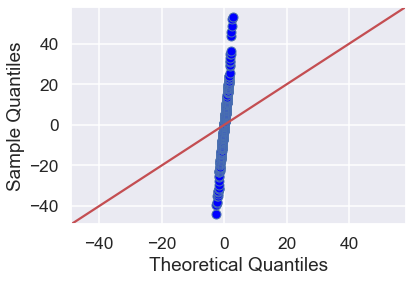

In [88]:
sm.qqplot(data = lsdv_model.resid, line = '45')
plt.show()

**Are residuals homoskedastic?**

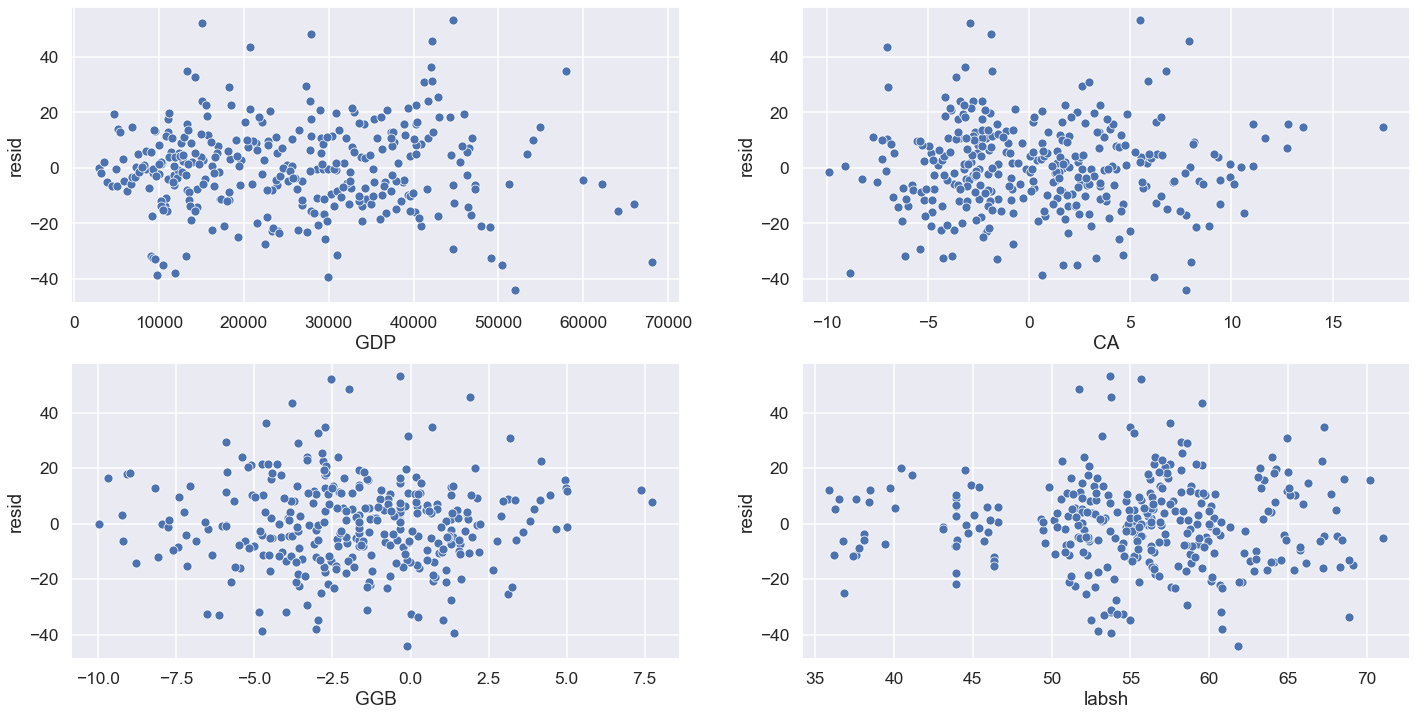

In [89]:
data['resid'] = lsdv_model.resid
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 12))

for ix, c in enumerate(X_var_names):
    plt.sca(ax[ix//2, ix%2])
    sns.scatterplot(data = data, x = c, y = 'resid')

**Are the errors correlated with response variable y?**

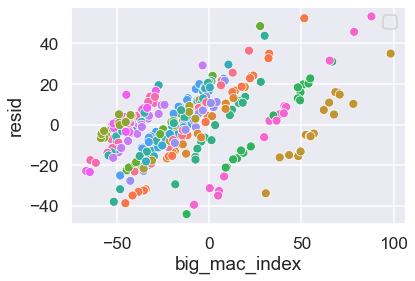

In [90]:
sns.scatterplot(data = data, x = 'big_mac_index', y = 'resid', hue = 'country_name')
plt.legend([],[])
plt.show()

In [91]:
# Show pearson correlation:
print(data[['resid','big_mac_index']].corr())

                  resid  big_mac_index
resid          1.000000       0.484242
big_mac_index  0.484242       1.000000


**Are the residuals autocorrelated?**

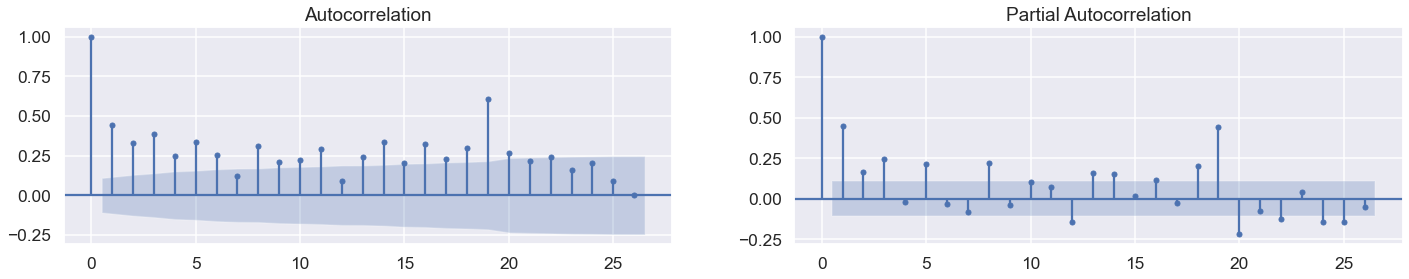

In [92]:
# Plot ACF & PACF:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 4))
tsaplots.plot_acf(data.resid, ax = ax[0])
tsaplots.plot_pacf(data.resid, ax = ax[1])
plt.show()

### 3. Random Effects Model - M2

In [93]:
# Number of Cross-sectional units
n = len(data['country_name'].drop_duplicates())

# Number of Time periods
T = len(data['year'].drop_duplicates())

# Number of observations
N = n*T

# Number of regression variables of the Pooled OLS Model
k = 4+1

# Calculate variance of error from fixed effect model
sigma2_epsilon = lsdv_model.ssr/(n*T-(n+k+1))
print('sigma2_epsilon = ' + str(sigma2_epsilon))

# Calculate pooled variance of error from pooled ols model
sigma2_pooled = pooled_ols_model.ssr/(n*T-(n+k+1))
print('sigma2_pooled = ' + str(sigma2_pooled))

# Calculate diff of the two variances
sigma2_u = sigma2_pooled - sigma2_epsilon
print('sigma2_u = ' + str(sigma2_u))

sigma2_epsilon = 264.8930838059377
sigma2_pooled = 585.1783862927157
sigma2_u = 320.285302486778


In [94]:
# Estimate group specific means
data_panel_group_means = data.groupby(unit_col_name).mean()
data_panel_group_means['const'] = 1.0

In [95]:
theta = 1 - math.sqrt(sigma2_epsilon/(sigma2_epsilon + T*sigma2_u))
print('theta = ' + str(theta))

theta = 0.7846092638012325


In [96]:
# prepare dataset for mean centering y & X columns
pooled_y_with_unit_name = pd.concat([data[unit_col_name], pooled_y], axis=1)
pooled_X_with_unit_name = pd.concat([data[unit_col_name], pooled_X], axis=1)

In [97]:
# Centering X
unit_name = ''
for row_index, row in pooled_X_with_unit_name.iterrows():
    for column_name, cell_value in row.items():
        if column_name == unit_col_name:
            unit_name = pooled_X_with_unit_name.at[row_index, column_name]
        else:
            pooled_X_group_mean = data_panel_group_means.loc[unit_name][column_name]
            pooled_X_with_unit_name.at[row_index, column_name] = pooled_X_with_unit_name.at[row_index, column_name] - theta*pooled_X_group_mean

In [98]:
# Centering y
unit_name = ''
for row_index, row in pooled_y_with_unit_name.iterrows():
    for column_name, cell_value in row.items():
        if column_name == unit_col_name:
            unit_name = pooled_y_with_unit_name.at[row_index, column_name]
        else:
            pooled_y_group_mean = data_panel_group_means.loc[unit_name][column_name]
            pooled_y_with_unit_name.at[row_index, column_name] = pooled_y_with_unit_name.at[row_index, column_name] - theta*pooled_y_group_mean

In [99]:
re_y=pooled_y_with_unit_name[list(pooled_y_with_unit_name.columns[1:])]
re_X=pooled_X_with_unit_name[list(pooled_X_with_unit_name.columns[1:])]

In [100]:
re_model = sm.OLS(endog=re_y, exog=re_X).fit()
print(re_model.summary())

                            OLS Regression Results                            
Dep. Variable:          big_mac_index   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.054
Method:                 Least Squares   F-statistic:                     5.554
Date:                Tue, 31 May 2022   Prob (F-statistic):           0.000247
Time:                        00:29:49   Log-Likelihood:                -1362.2
No. Observations:                 323   AIC:                             2734.
Df Residuals:                     318   BIC:                             2753.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -75.0568     23.578     -3.183      0.0

### Analysis of Residual Errors

**Are residuals normally distributed with Mean 0?**

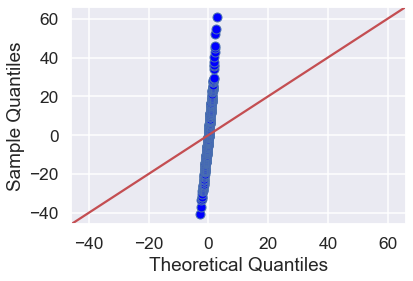

In [101]:
sm.qqplot(data = re_model.resid, line = '45')
plt.show()

**Are residuals homoskedastic?**

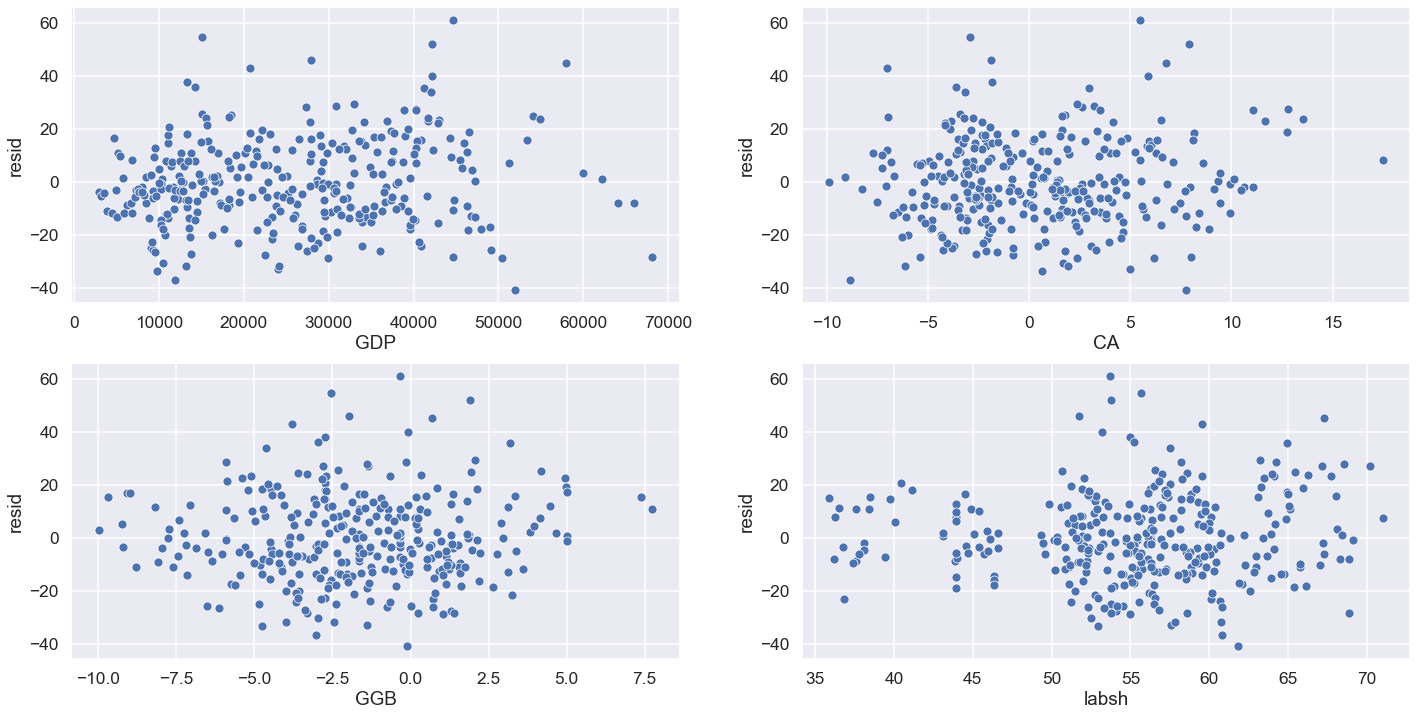

In [102]:
data['resid'] = re_model.resid
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (24, 12))

for ix, c in enumerate(X_var_names):
    plt.sca(ax[ix//2, ix%2])
    sns.scatterplot(data = data, x = c, y = 'resid')

**Are the errors correlated with response variable y?**

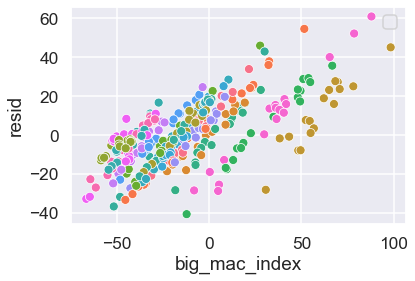

In [103]:
sns.scatterplot(data = data, x = 'big_mac_index', y = 'resid', hue = 'country_name')
plt.legend([],[])
plt.show()

In [104]:
# Show pearson correlation:
print(data[['resid','big_mac_index']].corr())

                  resid  big_mac_index
resid          1.000000       0.685539
big_mac_index  0.685539       1.000000


**Are the residuals autocorrelated?**

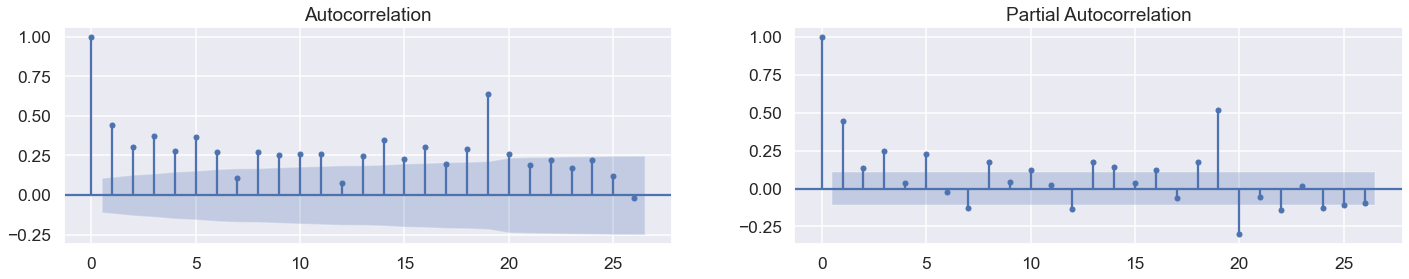

In [105]:
# Plot ACF & PACF:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (24, 4))
tsaplots.plot_acf(data.resid, ax = ax[0])
tsaplots.plot_pacf(data.resid, ax = ax[1])
plt.show()

### Perform Pooled, FE, and RE Regressions using pre-defined classes

In [55]:
# Load Data
data = pd.read_csv('processed_data_I.csv')
data.drop(['Unnamed: 0'], axis = 1, inplace = True)
data = data.loc[data['iso_a3'] != 'USA']

# Update columns & country names to have no spaces
data.rename(columns = {'GDP per capita': 'GDP',
                       'Curr Acc Balance': 'CA',
                       'labor comp per capita': 'labsh'}, inplace = True)
data['country_name'] = data['country_name'].str.replace(' ', '_')

In [66]:
#convert year to datetime
data['year'] = pd.to_datetime(data['year'], format='%Y')

#add column year to index
data = data.set_index('year', append=True)

data.head()

,,iso_a3,country_name,local_price,dollar_ex,dollar_price,big_mac_index,relative_PPP,GDP,CA,GGB,labsh,big_mac_affordability
,year,,,,,,,,,,,,
0,2000-01-01,AUS,Australia,2.59,1.68,1.541667,-38.579017,1.021867,26343.076700,-3.726699,-1.292779,60.654604,46.814798
1,2000-01-01,BRA,Brazil,2.95,1.79,1.648045,-34.340849,1.264648,9060.788667,-3.808026,-4.854256,53.780651,15.062746
2,2000-01-01,CAN,Canada,2.85,1.47,1.938776,-22.757948,0.885974,29362.084160,2.483228,2.639704,65.389532,41.492203
3,2000-01-01,CHE,Switzerland,5.90,1.70,3.470588,38.270448,2.294062,36772.694620,10.613576,0.281338,67.216617,29.028828
4,2000-01-01,CHL,Chile,1260.00,514.00,2.451362,-2.336181,92.466812,9538.075278,-1.152730,1.303082,49.851754,10.660080


In [67]:
# Perform PooledOLS
from linearmodels import PooledOLS
import statsmodels.api as sm

exog = sm.tools.tools.add_constant(data[['GDP','CA','GGB','labsh']])
endog = data['big_mac_index']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)

# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

In [73]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects

exog = sm.tools.tools.add_constant(data[['GDP','CA','GGB','labsh']])
endog = data['big_mac_index']

# random effects model
#model_re = RandomEffects(endog, exog) 
#re_res = model_re.fit() 

# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True) 
fe_res = model_fe.fit() 

#print results
#print(re_res)
print(fe_res)

AbsorbingEffectError: 
The model cannot be estimated. The included effects have fully absorbed
one or more of the variables. This occurs when one or more of the dependent
variable is perfectly explained using the effects included in the model.

The following variables or variable combinations have been fully absorbed
or have become perfectly collinear after effects are removed:

          const, GDP, CA, GGB, labsh
          const, GDP, CA, GGB, labsh
          const, GDP, CA, GGB, labsh
          const, GDP, CA, GGB, labsh

Set drop_absorbed=True to automatically drop absorbed variables.
